# Trabalho 01

Este *notebook* tem como objetivo aplicar todos os conceitos aprendidos no processamento do sinal
para o *dataset -* 8 SSVEP-BCI no modo *offline*.

**Nota:** O arquivo `requirements.txt` contém todas as dependências necessárias.
Para instalar (no linux), basta fazer:

```
$ pip install -r ../requirements.txt
```

In [250]:
# bloco apenas com organizações de imports
from google_drive_downloader import GoogleDriveDownloader as gdd
import numpy as np
import json
import matplotlib
import mne
from scipy.signal import stft
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

%matplotlib inline

## Preparação do *dataset* de trabalho

In [251]:
# bloco de declaração dos identificadores de download (google drive) e setup
dataset_ids = {
    1: '1ym3JqI4_ZYNSBLxoF1vNxI5Hsgur_tha',
    2: '1tJ5tHbE-2jwr0gA33Gd873lRPao-e4dF',
    3: '1tXdpY-mser01POaP6Qwixny6LjsXXoXB',
    4: '1T00cliWp5yqqbbWZ7-rf2X4tOUQ-PvIQ',
    5: '1CYsBFMul9zB_vCy0XD7XVfKUl8vihDYZ',
    6: '1io6jdALBKeopELWXahPzuAi6EfYDgviW',
    7: '1YDkheRDPNDR1ujsqqC_SY6cebWHkw9Xt',
    8: '1jjoQJFDCi7O9Q-iaReAPpQnxC-HIKpQi',
}
label_id = '1mD5MXoh6tfQJFXIvdw2MQsEu6vZka6C0'
desc = '14kYNBZYdttqmSS_Vz6Bm_ztG9Uw1MC0y'

# ALTERE O ID DO DATASET DE SUA ESCOLHA AQUI - NO CASO O 8
DS = 8

In [252]:
# download do stataset
gdd.download_file_from_google_drive(file_id=dataset_ids[DS],
                                    dest_path='files/data.npy',
                                    showsize=True)
# download do arquivo de marcações
gdd.download_file_from_google_drive(file_id=label_id,
                                    dest_path='files/labels.npy', showsize=True)

# download do arquivo de descrição
gdd.download_file_from_google_drive(file_id=desc,
                                    dest_path='files/descriptor.json',
                                    showsize=True)

In [253]:
# carregamento do dataset
X = np.load('files/data.npy')
y = np.load('files/labels.npy')
desc_file = open('files/descriptor.json')
descriptor = json.loads(desc_file.read())
desc_file.close()
print('Estruturas => dados', X.shape, 'labels', y.shape)

Estruturas => dados (125, 257, 1205) labels (125,)


Os dados estão estruturados em *numpy arrays*.

O "shape" `(125, 257, 1205)` para os dados EEG de `X`, significa que existem 125 *trials* (tradução aceitável: ensaio, julgamento), 257 *channels* que representam os eletrodos e 1205 dados que representam o potencial mensurado em ponto flutuante. Este é um array com **três dimensões**.

O "shape" `(125,)` para os dados de *labels* ou marcadores `y`, apresentam qual é o eletrodo respectivo a cada *trial*. Os *labels* estão com valores numéricos, o que facilita o processamento, mas não é intuitivo. 

Desta forma, foi preparado um arquivo de descrição no qual é possível saber qual é o rótulo do *dataset*, além de outras informações como a taxa de amostragem (sampling rate), idade, tipo do cabelo (curto, médio ou comprido), sexo, tamanho da touca e se é destro ou canhoto. Veja os dados do voluntário escolhido:

In [254]:
print('Características do voluntário:', descriptor[str(DS)])
print('\nRótulos:', descriptor['frequencies'])
print('\nTaxa de amostragem:', descriptor['sampling_rate'])

Características do voluntário: {'age': '25', 'capsize': 'Adult Medium', 'gender': 'Male', 'hairtype': 'Regular', 'handedness': 'Right'}

Rótulos: {'1': 6.66, '2': 7.5, '3': 8.57, '4': 10.0, '5': 12.0}

Taxa de amostragem: 250


Apesar do autor do *dataset* apresentar a taxa de amostragem da captura dos dados igual a 250 Hz, o mesmo não foi verificado por meio dos dados. Os dados dos voluntários estão desbalanceados em quantidade, o que não nos permite criar um `numpy.array`, que permite apenas vetores não esparsos. Desta forma, teremos que recalcular a taxa de amostragem (*sample rate*)

In [255]:
# quantidade_de_dados / tempo_do_trial
descriptor['sampling_rate'] = X.shape[-1] / 5
print('Nova taxa de amostragem: {} Hz'.format(descriptor['sampling_rate']))

Nova taxa de amostragem: 241.0 Hz


## Utilizando MNE para representar e trabalhar com os dados

A biblioteca MNE é usada para representar os dados de EEG, facilitando o armazenamento de todas as informações em um único objeto.

Além disso, somente a biblioteca MNE permite executar diversas operações de pré-processamento do *dataset*, além de outras operações utilizadas durante o processamento SSVEP.

### MNE *info descriptor*

O primeiro passo é criar um objeto `info`, que servirá como descrição do objeto MNE. Os valores mais importantes de descrição do objeto são: nome dos eletrodos, taxa de amostragem e tipo do sinal.

In [256]:
# aumentando a escala das figuras no matplotlib (padrão 6. x 4.)
matplotlib.rcParams['figure.figsize'] = [12, 8]

# objeto com o nome dos canais pelo modelo da touca utilizada
montage = mne.channels.make_standard_montage('EGI_256')

# criando o objeto `info` (o restante dos valores já temos)
info = mne.create_info(montage.ch_names,
                       sfreq=descriptor['sampling_rate'],
                       ch_types='eeg')

info.set_montage(montage)
info

<Info | 8 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 256 EEG
 custom_ref_applied: False
 dig: 259 items (3 Cardinal, 256 EEG)
 highpass: 0.0 Hz
 lowpass: 120.5 Hz
 meas_date: unspecified
 nchan: 256
 projs: []
 sfreq: 241.0 Hz
>

Podemos verificar que o nome dos canais não nos ajudou muito. Isto ocorre porque o modelo utilizado não é o "padrão 10-20" ou "padrão 10-05". Desta forma, nome de canais como `O1`, `O2`, `Pz` não estarão explícitos para consulta e outras operações.

Vamos então utilizar informações do artigo, no qual são mostradas alguns mapeamentos destes nomes genéricos (`E1`, `E2`, etc) para os nomes no padrão internacional 10-20:

| 256 HCGSN | 10-20 System | 256 HCGSN | 10-20 System | 256 HCGSN | 10-20 System | 256 HCGSN | 10-20 System |
|:---------:|:------------:|:---------:|:------------:|:---------:|:------------:|:---------:|:------------:|
|     47    |      F7      |     21    |      Fz      |    202    |      T8      |     31    |      NAS     |
|     37    |      Fp1     |    183    |      C4      |    116    |      O1      |     69    |      T7      |
|     36    |      F3      |    170    |      P8      |     94    |      LM      |    190    |      RM      |
|     2     |      F8      |    150    |      O2      |     18    |      Fp2     |    126    |      Oz      |
|    101    |      Pz      |    224    |      F4      |     96    |      P7      |

Além desse mapeamento aproximado, podemos comparar outros, por meio de mapeamentos dos padrões armazenados na própria biblioteca:

EGI 256
Creating RawArray with float64 data, n_channels=256, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


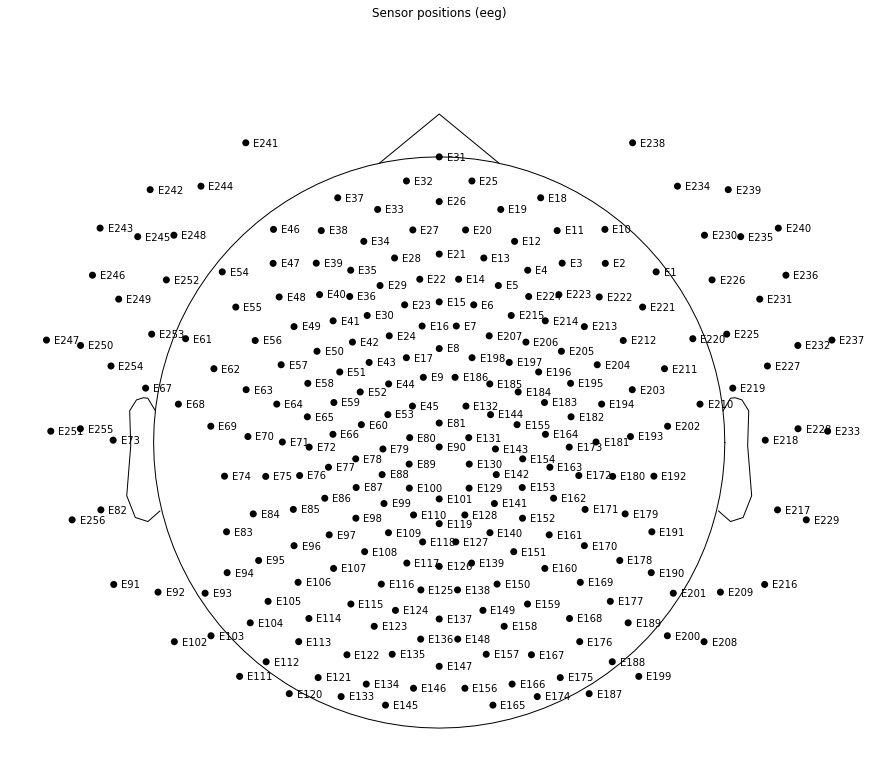

10-20 SYSTEM
4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


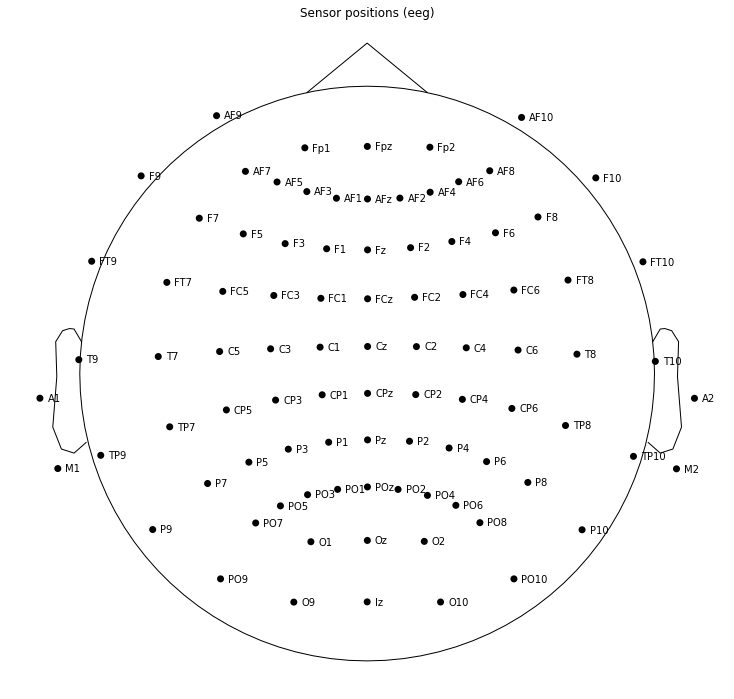

In [257]:
# plotando o padrão EGI 256
print('EGI 256')
montage.plot()

# plotando o padrão 10-20
print('10-20 SYSTEM')

matplotlib.rcParams['figure.figsize'] = [10, 7]
mne.channels.make_standard_montage('standard_1020').plot()
print()

### Criando objeto MNE Epoch

A princípio, precisamos preparar o parâmetro `events` do objeto `EpochArray`, que armazena os marcadores do experimento (aqueles marcadores que estão armazenados no nosso objeto `descriptor`).

Por fim, adicionamos o parâmetro `info` que acabamos de criar.

In [258]:
# o 257º eletrodo é o VREF (referência). Podemos tirá-lo.
X = X[:,:256,:]

# objeto event é uma matriz tridimensional conforme explicado em aula
events = np.array([[i, 0, e] for i, e in enumerate(y)])

# instanciando objeto EpochArray
epoch = mne.EpochsArray(X, info, events=events)
epoch

125 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


<EpochsArray  |   125 events (all good), 0 - 4.99585 sec, baseline off, ~294.8 MB, data loaded,
 '1': 25
 '2': 25
 '3': 30
 '4': 25
 '5': 20>

### Iniciando trabalhos com MNE Epoch

Com o objeto MNE criado, podemos realizar as operações.

A primeira coisa que faremos é filtrar alguns eletrodos de maior interesse (p/ experimentos SSVEP) e visualizar os plots básicos.

In [259]:
# Filtrando apenas dados dos eletrodos (O1, Oz e O2), (P7-P7-P8) e (PO7-POz-PO8)
epoch_ex = epoch.copy().pick_channels(['E116', 'E126', 'E150', 'E96', 'E97', 'E98', 'E99', 'E101', 'E141', 
                               'E152', 'E161', 'E170', 'E107', 'E108', 'E109', 'E119', 'E140', 'E151', 'E160'])
# 'E98', E99', 'E101', 'E141','E119'
# epoch_ex = epoch.copy().pick_channels(['E116', 'E126', 'E150', 'E96', 'E97', 
#                                 'E152', 'E161', 'E170', 'E107', 'E108', 'E109', 'E140', 'E151', 'E160'])

epoch_ex

<EpochsArray  |   125 events (all good), 0 - 4.99585 sec, baseline off, ~22.0 MB, data loaded,
 '1': 25
 '2': 25
 '3': 30
 '4': 25
 '5': 20>

Para demonstrar que estamos apenas com os eletrodos escolhidos, mostramos o shape de ambos os objetos criados.

In [260]:
print(epoch.get_data().shape)
print(epoch_ex.get_data().shape)

(125, 256, 1205)
(125, 19, 1205)


In [261]:
matplotlib.rcParams['figure.figsize'] = [8., 6.]

# CAR
epo_ref = mne.set_eeg_reference(epoch_ex, ref_channels=['E116', 'E126', 'E150'])
epo_ref

# Limitando as frequências
fmin = 5.0
fmax = 14.0

# filtros
epo_hp = epo_ref[0].copy().filter(l_freq=None, h_freq=fmax)
epo_lp = epo_ref[0].copy().filter(l_freq=fmin, h_freq=None)
epo_bp = epo_ref[0].copy().filter(l_freq=fmin, h_freq=fmax)
epo_bp2 = epo_ref[0].copy().filter(l_freq=fmin, h_freq=None)
epo_bp2.filter(l_freq=None, h_freq=fmax)

# CAR
# epo_ref_hp = mne.set_eeg_reference(epo_hp, ref_channels=['E116', 'E126', 'E150'])
# epo_ref_lp = mne.set_eeg_reference(epo_lp, ref_channels=['E116', 'E126', 'E150'])
# epo_ref_bp = mne.set_eeg_reference(epo_bp, ref_channels=['E116', 'E126', 'E150'])
# epo_ref_bp2 = mne.set_eeg_reference(epo_bp2, ref_channels=['E116', 'E126', 'E150'])

# filtros 2x
# epo_bp2 = epo_bp2.copy().filter(l_freq=fmin, h_freq=None)
# epo_bp2.filter(l_freq=None, h_freq=fmax)

EEG channel type selected for re-referencing
Applying a custom EEG reference.
Setting up low-pass filter at 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 227 samples (0.942 sec)

Setting up high-pass filter at 5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Filter length: 399 samples (1.656 sec)

Setting up band-pass filter from 5 - 14 Hz

FIR filter parameters
---------------------
Designing a one-

<EpochsArray  |   125 events (all good), 0 - 4.99585 sec, baseline off, ~22.0 MB, data loaded,
 '1': 25
 '2': 25
 '3': 30
 '4': 25
 '5': 20>

## Etapa de Pré-Processamento

### Filtros temporais

#### High pass filter

Evento:  1
    Using multitaper spectrum estimation with 7 DPSS windows


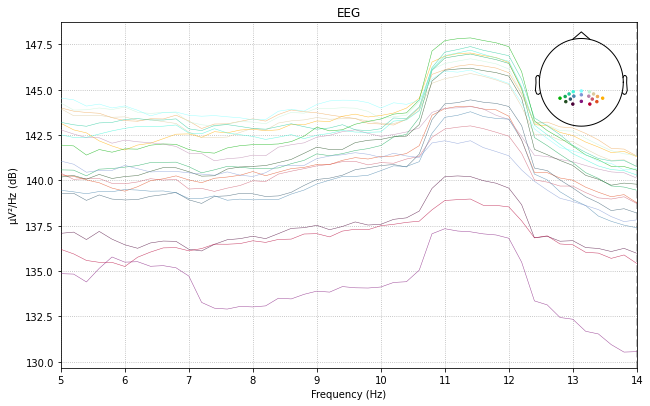

Evento:  2
    Using multitaper spectrum estimation with 7 DPSS windows


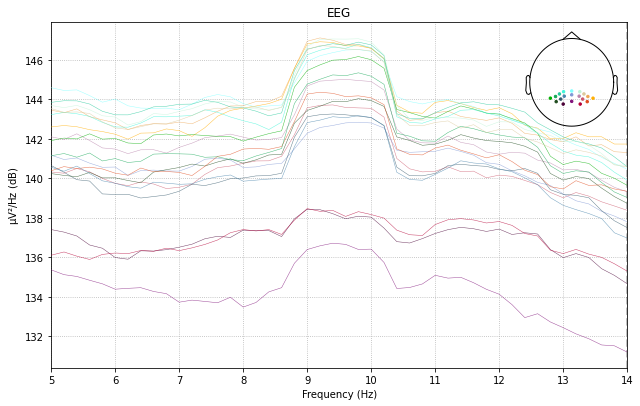

Evento:  3
    Using multitaper spectrum estimation with 7 DPSS windows


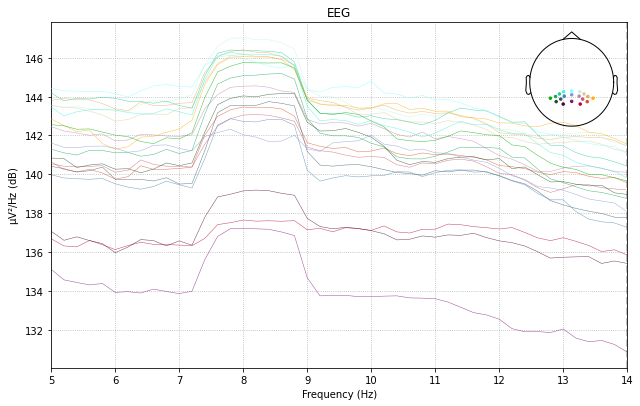

Evento:  4
    Using multitaper spectrum estimation with 7 DPSS windows


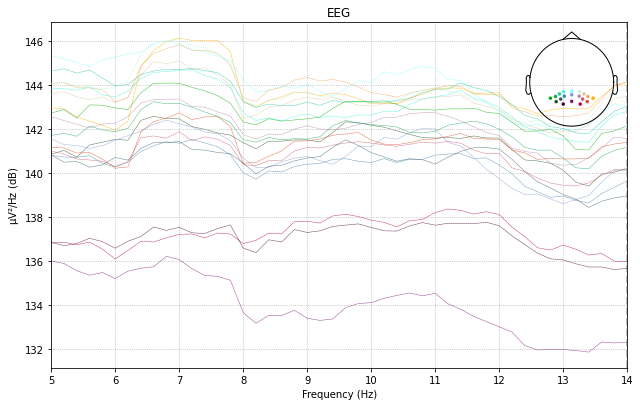

Evento:  5
    Using multitaper spectrum estimation with 7 DPSS windows


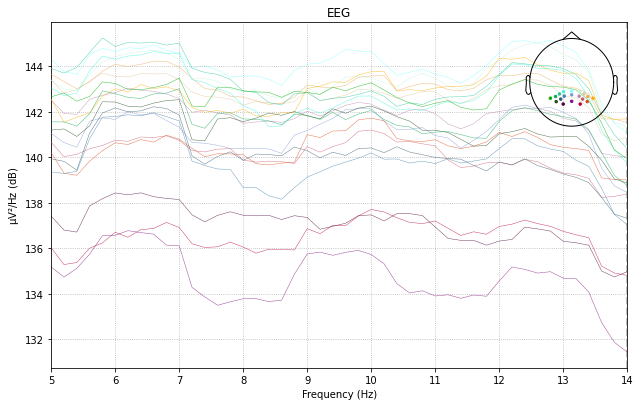

In [262]:
# filtrando os eventos
for e in ('1', '2', '3', '4', '5'):
    print("Evento: ", e)
    # selecionando os trials (1, 3, 9 e 11)
    # for i in (1, 5, 10, 15, 20):
        # print("Evento: ", e)
        # print("Trial: ", i)
        # epo_hp[e][-i].plot_psd(fmin=fmin, fmax=fmax)
    # mostrando todos os trials dos eventos
    matplotlib.rcParams['figure.figsize'] = [10., 6.]
    epo_hp[e].plot_psd(fmin=fmin,fmax=fmax)
print()

#### Low pass filter

Evento:  1
    Using multitaper spectrum estimation with 7 DPSS windows


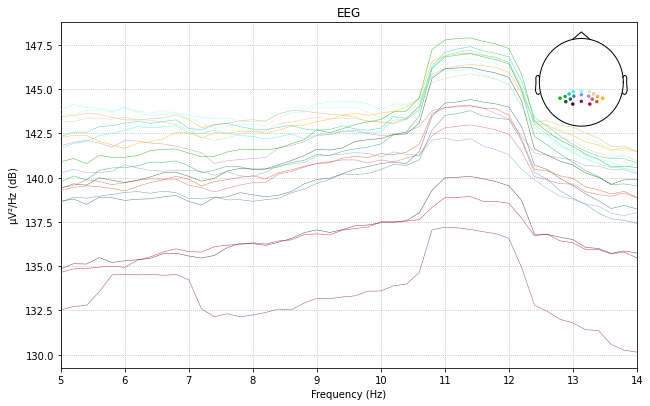

Evento:  2
    Using multitaper spectrum estimation with 7 DPSS windows


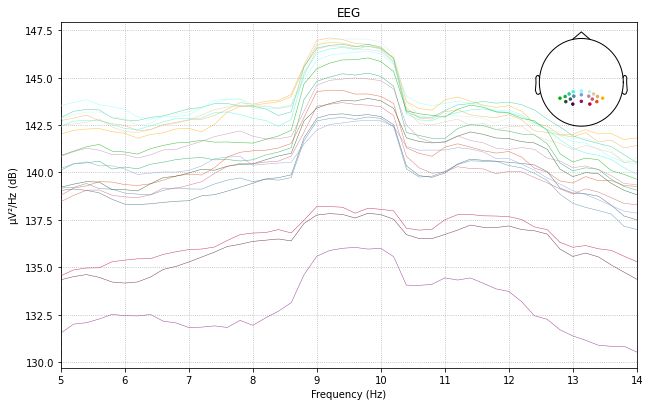

Evento:  3
    Using multitaper spectrum estimation with 7 DPSS windows


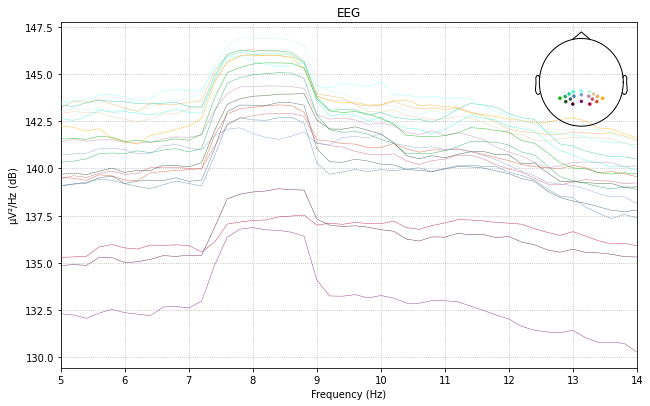

Evento:  4
    Using multitaper spectrum estimation with 7 DPSS windows


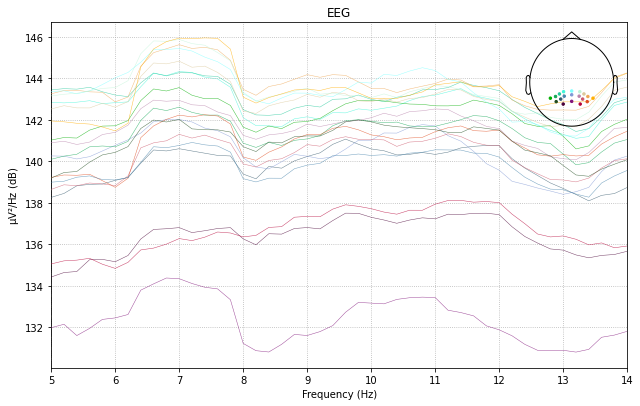

Evento:  5
    Using multitaper spectrum estimation with 7 DPSS windows


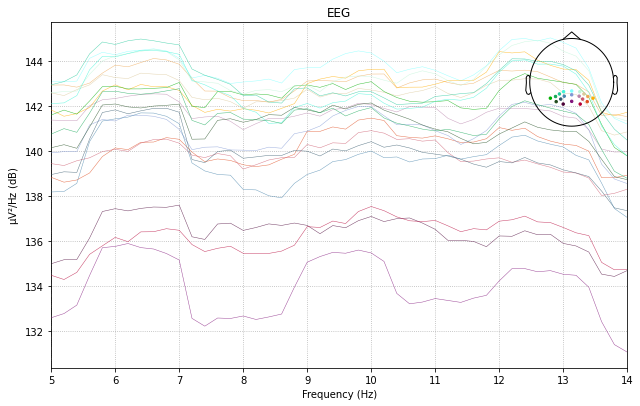

In [263]:
# filtrando os eventos
for e in ('1', '2', '3', '4', '5'):
    print("Evento: ", e)
    # selecionando os trials (1, 3, 9 e 11)
    # for i in (1, 5, 10, 15, 20):
        # print("Evento: ", e)
        # print("Trial: ", i)
        # epo_lp[e][-i].plot_psd(fmin=fmin, fmax=fmax)
    # mostrando todos os trials dos eventos
    matplotlib.rcParams['figure.figsize'] = [10., 6.]
    epo_lp[e].plot_psd(fmin=fmin,fmax=fmax)
print()

#### Band pass filter

Evento:  1
    Using multitaper spectrum estimation with 7 DPSS windows


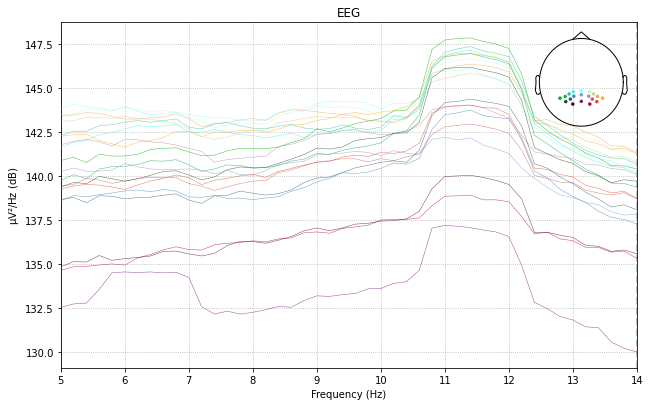

Evento:  2
    Using multitaper spectrum estimation with 7 DPSS windows


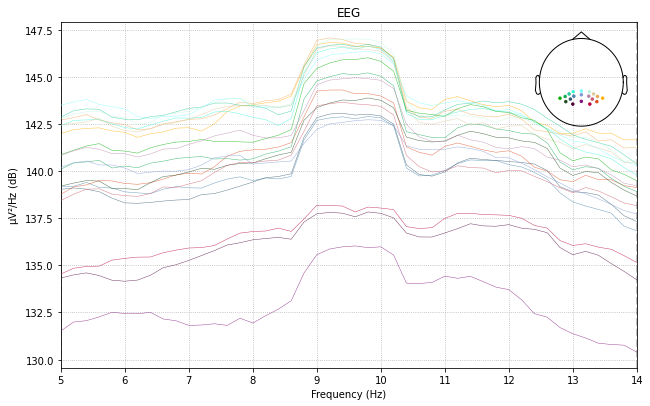

Evento:  3
    Using multitaper spectrum estimation with 7 DPSS windows


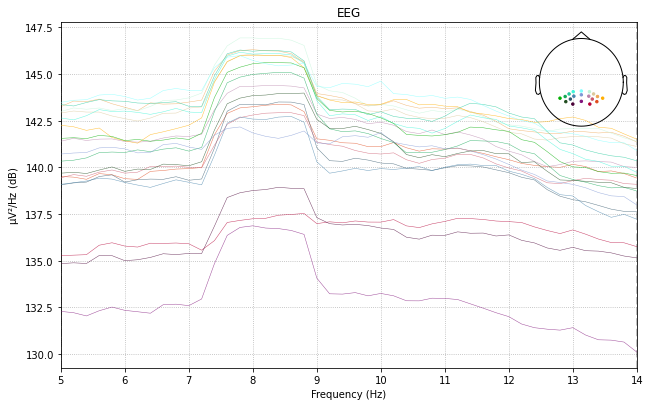

Evento:  4
    Using multitaper spectrum estimation with 7 DPSS windows


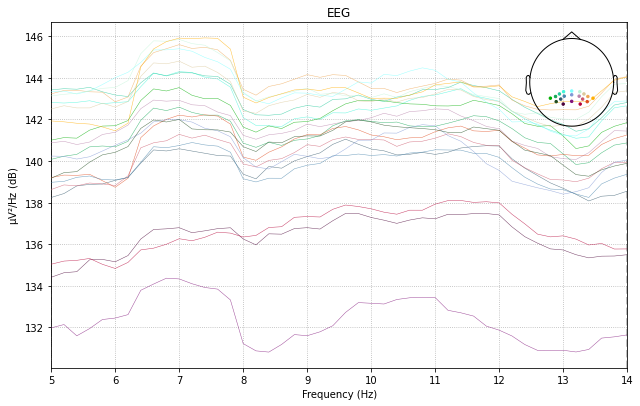

Evento:  5
    Using multitaper spectrum estimation with 7 DPSS windows


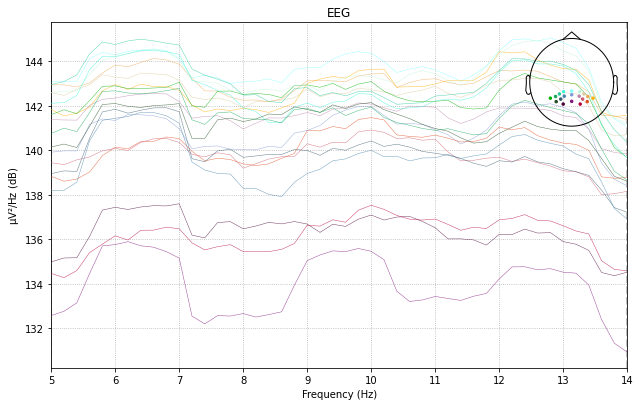

In [264]:
# filtrando os eventos
for e in ('1', '2', '3', '4', '5'):
    print("Evento: ", e)
    # selecionando os trials (1, 3, 9 e 11)
    # for i in (1, 5, 10, 15, 20):
        # print("Evento: ", e)
        # print("Trial: ", i)
        # epo_bp[e][-i].plot_psd(fmin=fmin, fmax=fmax)
    # mostrando todos os trials dos eventos
    matplotlib.rcParams['figure.figsize'] = [10., 6.]
    epo_bp[e].plot_psd(fmin=fmin,fmax=fmax)
print()

#### Band pass filter 2

Evento:  1
    Using multitaper spectrum estimation with 7 DPSS windows


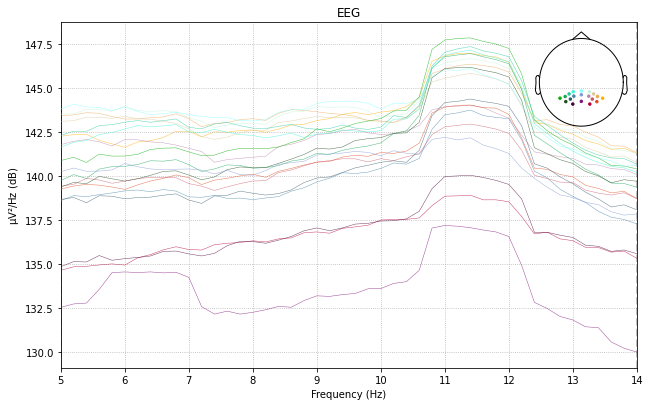

Evento:  2
    Using multitaper spectrum estimation with 7 DPSS windows


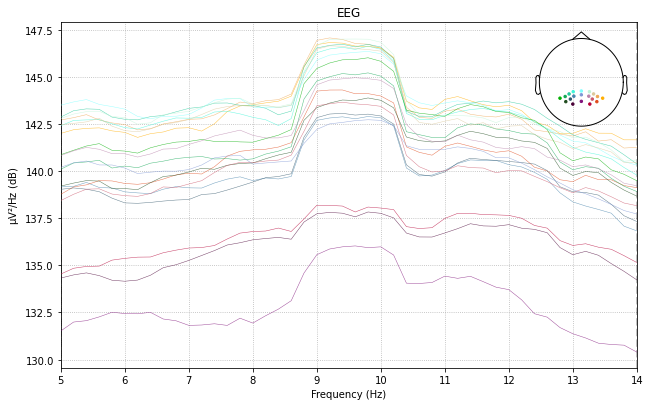

Evento:  3
    Using multitaper spectrum estimation with 7 DPSS windows


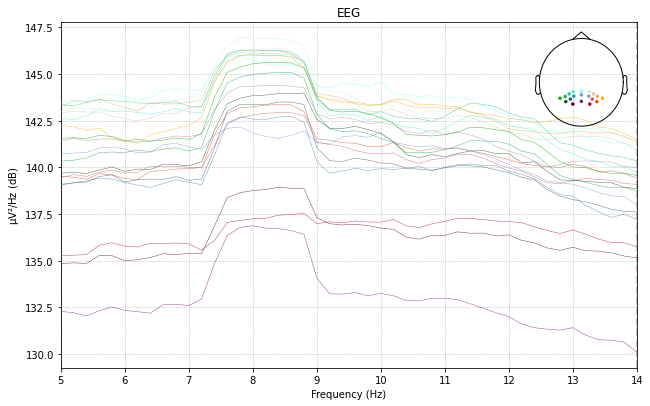

Evento:  4
    Using multitaper spectrum estimation with 7 DPSS windows


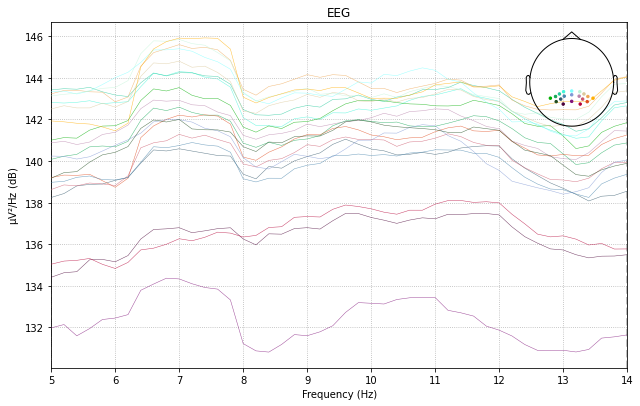

Evento:  5
    Using multitaper spectrum estimation with 7 DPSS windows


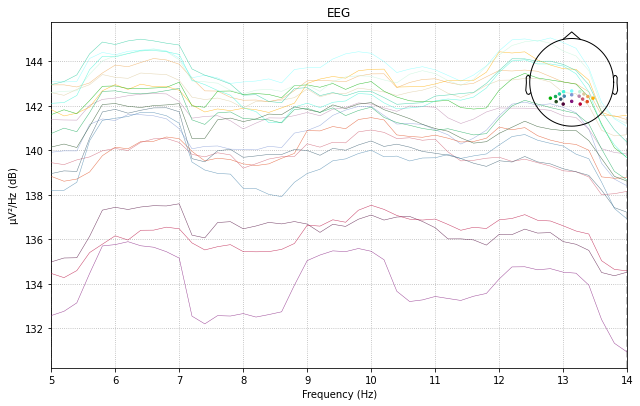

In [265]:
# filtrando os eventos
for e in ('1', '2', '3', '4', '5'):
    print("Evento: ", e)
    # selecionando os trials (1, 3, 9 e 11)
    # for i in (1, 5, 10, 15, 20):
        # print("Evento: ", e)
        # print("Trial: ", i)
        # epo_bp2[e][-i].plot_psd(fmin=fmin, fmax=fmax)
    # mostrando todos os trials dos eventos
    matplotlib.rcParams['figure.figsize'] = [10., 6.]
    epo_bp2[e].plot_psd(fmin=fmin,fmax=fmax)
print()

#### Notch filter

In [266]:
a = epoch.copy().pick_channels(['E116', 'E126', 'E150', 'E96', 'E97', 'E98', 'E99', 'E101', 'E141', 
                        'E152', 'E161', 'E170', 'E107', 'E108', 'E109', 'E119', 'E140', 'E151', 'E160'])
a = a.get_data()
a = a.transpose(1, 0, 2)
a = a.reshape(a.shape[0], a.shape[1]* a.shape[2])
# a = a.reshape(14, 125 * 1205)

# criando o objeto `info` (o restante dos valores já temos)
info = mne.create_info(ch_names=['E116', 'E126', 'E150', 'E96', 'E97', 'E98', 'E99', 'E101', 'E141', 
                        'E152', 'E161', 'E170', 'E107', 'E108', 'E109', 'E119', 'E140', 'E151', 'E160'],
                       sfreq=241.,
                       ch_types='eeg')

rawCAR = mne.io.RawArray(a, info)
raw = mne.io.RawArray(a, info)

Creating RawArray with float64 data, n_channels=19, n_times=150625
    Range : 0 ... 150624 =      0.000 ...   624.996 secs
Ready.
Creating RawArray with float64 data, n_channels=19, n_times=150625
    Range : 0 ... 150624 =      0.000 ...   624.996 secs
Ready.


CAR
EEG channel type selected for re-referencing
Applying a custom EEG reference.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1591 samples (6.602 sec)

Effective window size : 8.498 (s)


<ipython-input-267-0910c4edce4f>:9: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epo_ref[0].plot_psd(fmin=fmin,fmax=fmax)


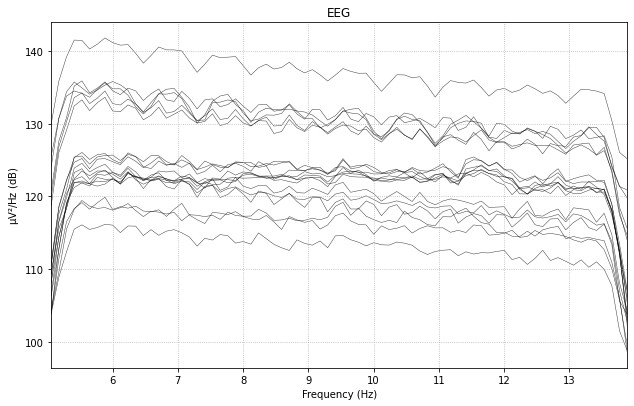

In [267]:
print("CAR")
epo_ref = mne.set_eeg_reference(rawCAR, ref_channels=['E116', 'E126', 'E150'])

# raw.notch_filter?
epo_ref[0].notch_filter(freqs=(5, 14), picks=['eeg'])
# mne.filter.filter_data(raw, sfreq=241, l_freq=5, h_freq=14)
# raw.notch_filter(np.arange(50, 251, 50))
matplotlib.rcParams['figure.figsize'] = [10., 6.]
epo_ref[0].plot_psd(fmin=fmin,fmax=fmax)
print()

Sem CAR
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1591 samples (6.602 sec)

Effective window size : 8.498 (s)


<ipython-input-268-5986a8a0ba84>:8: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmin=fmin,fmax=fmax)


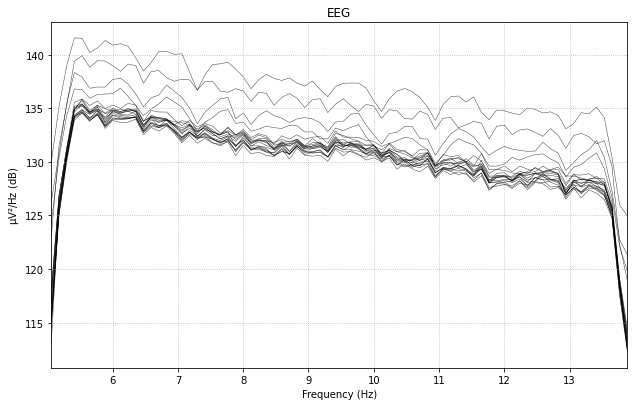

In [268]:
print("Sem CAR")

# raw.notch_filter?
raw.notch_filter(freqs=(5, 14), picks=['eeg'])
# mne.filter.filter_data(raw, sfreq=241, l_freq=5, h_freq=14)
# raw.notch_filter(np.arange(50, 251, 50))
matplotlib.rcParams['figure.figsize'] = [10., 6.]
raw.plot_psd(fmin=fmin,fmax=fmax)
print()

### Salvando no sistema de arquivos

In [269]:
epo_ref[0].save('files/ssvep-raw.fif', overwrite=True)

Overwriting existing file.
Writing /home/yyy/rp360/trabalho01/files/ssvep-raw.fif
Closing /home/yyy/rp360/trabalho01/files/ssvep-raw.fif [done]


In [270]:
epo_bp2.save('files/ssvep-epo.fif', overwrite=True)

Overwriting existing file.


In [271]:
# carregamento do dataset (FIF file)
epochs_bp2 = mne.read_epochs('files/ssvep-epo.fif')
raw_notch = mne.io.read_raw_fif('files/ssvep-raw.fif')

Reading files/ssvep-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    4995.85 ms
        0 CTF compensation matrices available
125 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Opening raw data file files/ssvep-raw.fif...
Isotrak not found
    Range : 0 ... 150624 =      0.000 ...   624.996 secs
Ready.


In [272]:
raw_notch.info.get('nchan')

19

In [273]:
raw_notch.get_data().shape

(19, 150625)

## Segmentação e criação do vetor de características

### Transformação de domínio

In [274]:
# Band pass
data = epochs_bp2.get_data()
print(data.shape)

# aplicando STFT BP
_, _, w = stft(data, fs=241, nperseg=32, noverlap=16)
# w = np.swapaxes(w, 3, 4)
print(w.shape)

(125, 19, 1205)
(125, 19, 17, 77)


In [275]:
W = np.abs(w) ** 2
# w = np.reshape(w, (125, 13, 17 * 77)) # <= questão de projeto
# w = w.transpose(0, 2, 1)
# w = np.reshape(w, (125 * 1309, 13))
print(W.shape)

(125, 19, 17, 77)


In [276]:
# Notch
data2 = raw_notch.get_data()
print(data2.shape)

# aplicando STFT Notch
_, _, w2 = stft(data2, fs=241, nperseg=32, noverlap=16)
# w = np.swapaxes(w, 3, 4)
print(w2.shape)

(19, 150625)
(19, 17, 9416)


In [277]:
W2 = np.abs(w2) ** 2
print(W2.shape)

(19, 17, 9416)


### Extração de características

In [278]:
fmn = np.mean(W, axis=-1)
print('FMN:', fmn.shape)

# Root of sum of squares
rss = np.sqrt(np.sum(W, axis=-1))
print('RSS:', rss.shape)

FMN: (125, 19, 17)
RSS: (125, 19, 17)


In [279]:
fmn2 = np.mean(W2, axis=-1)
print('FMN:', fmn2.shape)

# Root of sum of squares
rss2 = np.sqrt(np.sum(W2, axis=-1))
print('RSS:', rss2.shape)

FMN: (19, 17)
RSS: (19, 17)


In [280]:
# realização das transformações finais (TAREFA)

# finalizando o exemplo com a junção das duas características criadas
features = list()
for feature in (fmn, rss,):
    feature = feature.transpose(0, 2, 1)
    feature = feature.reshape(feature.shape[0] * feature.shape[1],
                              feature.shape[2])
    features.append(feature)

# vetor de características final
X = np.concatenate(features, axis=-1)
print('Shape dos dados:', X.shape)

Shape dos dados: (2125, 38)


In [281]:
# finalizando o exemplo com a junção das duas características criadas
features2 = list()
for feature in (fmn2, rss2,):
    feature = feature.transpose(1, 0)
    features2.append(feature)

# vetor de características final
X2 = np.concatenate(features)
print('Shape dos dados:', X2.shape)

Shape dos dados: (4250, 19)


#### Adaptação do vetor de labels

In [282]:
print('Shape original dos labels', y.shape)

size = int(X.shape[0] / y.shape[0])
y = np.concatenate([y for i in range(size)])
print('Shape final dos labels', y.shape)

Shape original dos labels (125,)
Shape final dos labels (2125,)


In [283]:
print('Shape original dos labels', y.shape)

size2 = int(X2.shape[0] / y.shape[0])
y2 = np.concatenate([y for i in range(size2)])
print('Shape final dos labels', y2.shape)

Shape original dos labels (2125,)
Shape final dos labels (4250,)


## Classificação

### Métodos de classificação

In [434]:
# dividindo as porções de dados em treino e teste (70 e 30% respectivamente)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, shuffle=True)

In [435]:
# TODO: aplicação de diferentes parametrizações
clf = SVC(gamma='auto')
clf.fit(X_train, y_train)

SVC(gamma='auto')

In [436]:
res = clf.predict(X_test)
tot_hit = sum([1 for i in range(len(res)) if res[i] == y_test[i]])
print('Acurácia: {:.2f}%'.format(tot_hit / X_test.shape[0] * 100))

Acurácia: 26.02%


In [437]:
# dividindo as porções de dados em treino e teste (70 e 30% respectivamente)
X_train, X_test, y_train, y_test = train_test_split(
    X2, y2, train_size=0.7, shuffle=True)

In [438]:
# TODO: aplicação de diferentes parametrizações
clf = SVC(gamma='auto')
clf.fit(X_train, y_train)

SVC(gamma='auto')

In [439]:
res = clf.predict(X_test)
tot_hit = sum([1 for i in range(len(res)) if res[i] == y_test[i]])
print('Acurácia: {:.2f}%'.format(tot_hit / X_test.shape[0] * 100))

Acurácia: 26.12%
